In [1]:
%load_ext tensorboard
import tensorflow as tf
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/fit/

log_dir = "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

checkpoint_filepath = 'checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0001)


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

from sqlalchemy import create_engine
from ast import literal_eval
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, MaxPooling1D, Conv1D, RepeatVector, TimeDistributed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost'

POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'vegas'
POSTGRES_PASSWORD = 'VrichCrich99'
POSTGRES_DBNAME = 'univers'

In [4]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)

In [5]:
appstech_labs_id = 1
df = pd.read_sql_query(f"SELECT discount_rate, discount_amount, sales_tax_rate, sales_tax_amount, exchange_rate, gross_cost, margin, gross_amount, txn_date FROM user_sales_table where appstech_labs_id='{appstech_labs_id}'", cnx, index_col='txn_date', parse_dates=['txn_date'])
df.head()

,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,exchange_rate,gross_cost,margin,gross_amount
txn_date,,,,,,,,
2020-07-26,0.0,0.00,0.0,0.00,1.0,0.0,140.00,140.00
2020-07-28,10.0,8.75,0.0,0.00,1.0,0.0,78.75,78.75
2020-07-05,0.0,0.00,0.0,0.00,1.0,0.0,225.00,225.00
2020-07-30,0.0,0.00,8.0,26.82,1.0,135.0,200.25,335.25
2020-07-30,0.0,0.00,0.0,0.00,1.0,167.5,310.00,477.50


In [6]:
df.shape

(32, 8)

In [7]:
threshold = 0.7
df.isna().sum()

discount_rate       0
discount_amount     0
sales_tax_rate      0
sales_tax_amount    0
exchange_rate       0
gross_cost          0
margin              0
gross_amount        0
dtype: int64

In [8]:
df = df[df.columns[df.isna().mean() < threshold]]
df = df.loc[df.isna().mean(axis=1) < threshold]

df.tail()

,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,exchange_rate,gross_cost,margin,gross_amount
txn_date,,,,,,,,
2020-06-11,0.0,0.00,0.0,0.0,1.0,0.00,75.00,75.00
2020-07-28,5.0,50.25,0.0,0.0,1.0,125.00,829.75,954.75
2020-07-27,0.0,0.00,0.0,0.0,1.0,0.00,103.55,103.55
2020-07-16,10.0,30.50,0.0,0.0,1.0,136.25,138.25,274.50
2020-07-28,0.0,0.00,0.0,0.0,1.0,0.00,375.00,375.00


In [9]:
upper_lim = df["gross_amount"].quantile(.95)
lower_lim = df["gross_amount"].quantile(.05)

print(f"upper limit {upper_lim} vs lower limit {lower_lim}")
df = df[(df["gross_amount"] < upper_lim) & (df["gross_amount"] > lower_lim)]

upper limit 750.0124999999997 vs lower limit 72.75


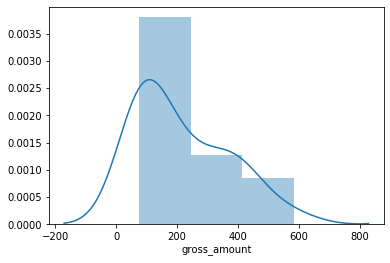

In [10]:
sns.distplot(df["gross_amount"])
plt.show()

In [11]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
# numeric_feats = df[numeric_feats].dtypes[df.dtypes != "datetime64[ns]"].index
# numeric_feats = df[numeric_feats].dtypes[df.dtypes != "int64"].index

imp_feats = []

cormat = df[numeric_feats].corr().fillna(0)

for feat in numeric_feats:
    try:
        if cormat[feat][-1] > 0.2:
            imp_feats.append(feat)
    except:
        pass
        

df = df[imp_feats]
df.head()

,sales_tax_rate,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,,
2020-07-26,0.0,0.00,0.0,140.00,140.00
2020-07-28,0.0,0.00,0.0,78.75,78.75
2020-07-05,0.0,0.00,0.0,225.00,225.00
2020-07-30,8.0,26.82,135.0,200.25,335.25
2020-07-30,0.0,0.00,167.5,310.00,477.50


In [12]:
# data = pd.DataFrame(df["gross_amount"])
# data["log+1"] = (data["gross_amount"] + 1).transform(np.log)
# data["log(x-min(x)+1)"] = (data["gross_amount"] - data["gross_amount"].min() + 1).transform(np.log)

# data["inverse_log"] = (data["log(x-min(x)+1)"]).transform(np.exp) + data["gross_amount"].min() - 1
# data

df["gross_amount"] = (df["gross_amount"] - df["gross_amount"].min() + 1).transform(np.log)
df.head()

,sales_tax_rate,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,,
2020-07-26,0.0,0.00,0.0,140.00,4.189655
2020-07-28,0.0,0.00,0.0,78.75,1.558145
2020-07-05,0.0,0.00,0.0,225.00,5.017280
2020-07-30,8.0,26.82,135.0,200.25,5.565478
2020-07-30,0.0,0.00,167.5,310.00,6.000176


In [13]:
_scaler = MinMaxScaler()
df["gross_amount"] = _scaler.fit_transform(df["gross_amount"].values.reshape(-1, 1))
df.head()

,sales_tax_rate,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,,
2020-07-26,0.0,0.00,0.0,140.00,0.672339
2020-07-28,0.0,0.00,0.0,78.75,0.250045
2020-07-05,0.0,0.00,0.0,225.00,0.805153
2020-07-30,8.0,26.82,135.0,200.25,0.893125
2020-07-30,0.0,0.00,167.5,310.00,0.962884


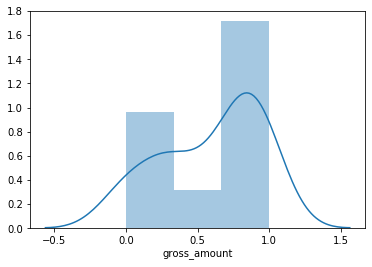

In [14]:
sns.distplot(df["gross_amount"])
plt.show()

In [15]:
df.head()

,sales_tax_rate,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,,
2020-07-26,0.0,0.00,0.0,140.00,0.672339
2020-07-28,0.0,0.00,0.0,78.75,0.250045
2020-07-05,0.0,0.00,0.0,225.00,0.805153
2020-07-30,8.0,26.82,135.0,200.25,0.893125
2020-07-30,0.0,0.00,167.5,310.00,0.962884


In [16]:
df = df.resample("D").sum()
df = df.loc[df["gross_amount"] > 0]

In [17]:
df.shape

(15, 5)

In [18]:
dataset = df.values
dataset.shape

(15, 5)

In [19]:
def split_sequences(data, look_back:int=3):
    x, y = list(), list()
    
    for i in range(len(data)):
        end_start = i + look_back
        
        if end_start > len(data):
            break
        
        x.append(data[i:end_start, :-1])
        y.append(data[end_start - 1, -1])
        
        end_start += 1
    
    return np.array(x), np.array(y)

x, y = split_sequences(dataset)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

(13, 3, 4) (13, 1)


In [20]:
x_train, y_train, x_test, y_test = x[:-6], y[:-6], x[-6:], y[-6:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7, 3, 4) (7, 1) (6, 3, 4) (6, 1)


In [ ]:
scores = list()
for epoch in [70, 140, 280, 400, 1120]: #400
    for in_units in [8, 16, 50, 256, 512]: #8
        for batch_size in [1, 5, 8, 18, 20]:#20,1
            model = Sequential()
            
#             model.add(Conv1D(filters=in_units, kernel_size=2, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2])))
#             model.add(MaxPooling1D(pool_size=2))
#             model.add(Flatten())
#             model.add(Dense(200, activation="softmax"))
#             model.add(Dense(y_train.shape[1]))
#             model.compile(optimizer="adam", loss="mse")
            
            
            model.add(LSTM(in_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
            model.add(LSTM(in_units, activation="linear"))
            model.add(Dense(100, activation='relu'))
            model.add(Dense(y_train.shape[1], activation='sigmoid'))

            model.compile(loss="mape", optimizer="adam", metrics=["mape"])
            

            model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=0)

            history = [i for i in x_train]
            pred = list()

            for i in range(len(x_test)):
                x_input = history[-1]
                x_input = x_input.reshape(-1, x_test.shape[1], x_test.shape[2])
                yhat = model.predict(x_input)
                pred.append(yhat)
                history.append(x_test[i])


            pred = np.array(pred)
            pred = pred.reshape(-1, pred.shape[1]*pred.shape[2])

            print(f"accuracy = {round(r2_score(y_true=y_test, y_pred=pred), 2)}\tepoch = {epoch}\tbatch_size = {batch_size}\tin_units = {in_units}")
        print("\n")
    print("\n")

        

accuracy = -1.28	epoch = 70	batch_size = 1	in_units = 8
accuracy = -1.53	epoch = 70	batch_size = 5	in_units = 8
accuracy = -1.45	epoch = 70	batch_size = 8	in_units = 8
accuracy = -1.66	epoch = 70	batch_size = 18	in_units = 8
accuracy = -1.59	epoch = 70	batch_size = 20	in_units = 8


accuracy = -0.58	epoch = 70	batch_size = 1	in_units = 16
accuracy = -1.0	epoch = 70	batch_size = 5	in_units = 16
accuracy = -1.59	epoch = 70	batch_size = 8	in_units = 16
accuracy = -1.56	epoch = 70	batch_size = 18	in_units = 16
accuracy = -1.62	epoch = 70	batch_size = 20	in_units = 16


accuracy = -1.26	epoch = 70	batch_size = 1	in_units = 50
accuracy = -0.78	epoch = 70	batch_size = 5	in_units = 50
accuracy = -0.94	epoch = 70	batch_size = 8	in_units = 50
accuracy = -0.99	epoch = 70	batch_size = 18	in_units = 50
accuracy = -0.89	epoch = 70	batch_size = 20	in_units = 50


accuracy = -0.74	epoch = 70	batch_size = 1	in_units = 256
accuracy = -0.93	epoch = 70	batch_size = 5	in_units = 256
accuracy = -0.99	epoch 